In [1]:
# Imports for xclim and xarray
import xclim as xc
import numpy as np
import xarray as xr
xr.set_options(display_style='html')

# =======
# import packages

# for data
import xarray as xr
import xarray.ufuncs as xu
import numpy as np
import xclim as xc
import datetime

import logging
logger = logging.getLogger(__name__)
#logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')

# for plotting
try:
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature;
    %matplotlib inline
except:
    logger.warning("Matplotlib and/or Cartopy is not installed in your python environment. Xarray Dataset plotting functions will not work.")

In [121]:
# Download ERA5 Fire Data for month August 2018
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'cems-fire-historical',
    {
        'format': 'zip',
        'variable': [
            'build_up_index', 'burning_index', 'danger_risk',
            'drought_code', 'duff_moisture_code', 'energy_release_component',
            'fine_fuel_moisture_code', 'fire_daily_severity_rating', 'fire_danger_index',
            'fire_weather_index', 'ignition_component', 'initial_fire_spread_index',
            'keetch_byram_drought_index', 'spread_component',
        ],
        'product_type': 'reanalysis',
        'year': '2018',
        'month': '08',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
        ],
        'dataset': 'Consolidated dataset',
        'version': '3.1',
    },
    '/home/steidani/windows/data/ecmwf/era5/2018_fwi/download.zip')

Result(content_length=128946843,content_type=application/zip,location=https://download-0002.copernicus-climate.eu/cache-compute-0002/cache/data3/dataset-cems-fire-historical-92a3d513-b386-470e-a776-77361c53a2fa.zip)

In [2]:
# read COSMO-1 data
ds = xr.open_mfdataset('/home/steidani/windows/data/meteoswiss/COSMO-1/analysis/cosmo-1_ana*.nc', parallel=True)
ds


<xarray.Dataset>
Dimensions:         (time: 316, x_1: 429, y_1: 294)
Coordinates:
  * time            (time) datetime64[ns] 2018-08-01 ... 2018-08-14T03:00:00
  * x_1             (x_1) float32 4.39e+05 4.4e+05 ... 8.66e+05 8.67e+05
  * y_1             (y_1) float32 4.05e+04 4.15e+04 ... 3.325e+05 3.335e+05
    lon_1           (y_1, x_1) float32 dask.array<chunksize=(294, 429), meta=np.ndarray>
    lat_1           (y_1, x_1) float32 dask.array<chunksize=(294, 429), meta=np.ndarray>
Data variables:
    grid_mapping_1  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    U_10M           (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    V_10M           (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    VMAX_10M        (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    T_2M            (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    RELHUM_2M       (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    PS              (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    Z0              (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    TOT_PREC        (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
Attributes:
    Conventions:     CF-1.6
    ConventionsURL:  http://cfconventions.org/cf-conventions/v1.6.0/cf-conven...
    institution:     MeteoSwiss (NMC Switzerland)
    source:          model: cosmo-1, production_status: unknown, version: 104...
    history:         Produced by fieldextra version v13.4.0 (v13.4.0) on 2021...

In [13]:
# take measured at 12noon
#ds_noon = ds.sel(time=datetime.time(12))
#ds_noon['TOT_PREC'] = ds_noon.TOT_PREC.assign_attrs(units='mm/d')
#ds_noon['T_2M'] = xc.units.convert_units_to(ds_noon.T_2M, 'degC')
#ds_noon['U_10M'] = xc.units.convert_units_to(ds_noon.U_10M, 'km/h')
#ds_noon['V_10M'] = xc.units.convert_units_to(ds_noon.V_10M, 'km/h')
#ds_noon = ds_noon.chunk({"time": -1})
#ds_noon.to_netcdf('/home/steidani/windows/data/meteoswiss/COSMO-1/analysis/test.nc') 

In [3]:
# time at 12 noon
ds_noon = ds.sel(time=datetime.time(12))

# for precip: daily mean
ds_noon['TOT_PREC'] = ds['TOT_PREC'].resample(time='1D').mean('time')

In [4]:
import numpy as np
import xarray as xr
import pandas as pd


# create dataset
ds_test = xr.Dataset({
    'TOT_PREC': xr.DataArray(
                data   = ds_noon['TOT_PREC'].values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'mm/d'
                    }
                ),
    'T_2M': xr.DataArray(
                data   = ds_noon['T_2M'].values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'degC'
                    }
                ),
    'U_10M': xr.DataArray(
                data   = ds_noon['U_10M'].values*3.6,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'km/h'
                    }
                ),
    'V_10M': xr.DataArray(
                data   = ds_noon['V_10M'].values*3.6,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'km/h'
                    }
                ),
    'RELHUM_2M': xr.DataArray(
                data   = ds_noon['RELHUM_2M'].values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : '%'
                    }
                ),
    'WIND': xr.DataArray(
                data   = xu.sqrt(ds_noon.U_10M**2 + ds_noon.V_10M**2).values*3.6,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'km/h'
                    }
                ),
            },
        attrs = {'example_attr': 'this is a global attribute'}
    )

In [5]:
ds_test

<xarray.Dataset>
Dimensions:    (lat: 294, lon: 429, time: 13)
Coordinates:
  * time       (time) datetime64[ns] 2018-08-01T12:00:00 ... 2018-08-13T12:00:00
  * lat        (lat) float32 45.5 45.51 45.52 45.52 ... 48.11 48.11 48.12 48.13
  * lon        (lon) float32 5.379 5.392 5.404 5.417 ... 10.81 10.83 10.84 10.85
Data variables:
    TOT_PREC   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    T_2M       (time, lat, lon) float32 301.2 302.2 302.2 ... 299.7 299.7 299.9
    U_10M      (time, lat, lon) float32 11.16 10.69 10.46 ... 18.77 18.77 20.09
    V_10M      (time, lat, lon) float32 -14.06 -11.19 -10.47 ... -3.85 -3.072
    RELHUM_2M  (time, lat, lon) float32 47.13 45.39 45.77 ... 40.35 40.35 40.81
    WIND       (time, lat, lon) float32 17.95 15.48 14.8 ... 19.17 19.17 20.32
Attributes:
    example_attr:  this is a global attribute

In [6]:
ds_test.lat

<xarray.DataArray 'lat' (lat: 294)>
array([45.497562, 45.506554, 45.515545, ..., 48.11405 , 48.12304 , 48.13203 ],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 45.5 45.51 45.52 45.52 ... 48.11 48.11 48.12 48.13

In [7]:
out = xc.indicators.atmos.fire_weather_indexes(tas=ds_test.T_2M, pr=ds_test.TOT_PREC, sfcWind=ds_test.WIND, hurs=ds_test.RELHUM_2M, lat=ds_test.lat)

In [18]:
out[1].isel(time=0)

<xarray.DataArray 'dmc' (lat: 294, lon: 429)>
array([[38.993633 , 40.19019  , 39.958523 , ..., 44.94376  , 45.21363  ,
        45.076683 ],
       [37.682194 , 39.08927  , 39.724403 , ..., 44.771088 , 45.079082 ,
        44.911324 ],
       [37.114983 , 37.903057 , 38.434612 , ..., 45.15765  , 44.643635 ,
        44.622055 ],
       ...,
       [14.675358 , 13.945137 , 13.088212 , ..., 40.20152  , 40.20152  ,
        40.740387 ],
       [14.904052 , 14.035538 , 13.196249 , ..., 40.67414  , 40.67414  ,
        40.34301  ],
       [15.269249 , 14.5371685, 13.998788 , ..., 40.869804 , 40.869804 ,
        40.208904 ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2018-08-01T12:00:00
  * lat      (lat) float32 45.5 45.51 45.52 45.52 ... 48.11 48.11 48.12 48.13
  * lon      (lon) float32 5.379 5.392 5.404 5.417 ... 10.81 10.83 10.84 10.85
Attributes:
    units:          
    cell_methods:   
    xclim_history:  tas: \npr: \nsfcWind: \nhurs: \n[2021-06-16 22:47:22] dmc...
    standard_name:  duff_moisture_code
    long_name:      Duff moisture code
    description:    Numeric rating of the average moisture content of loosely...

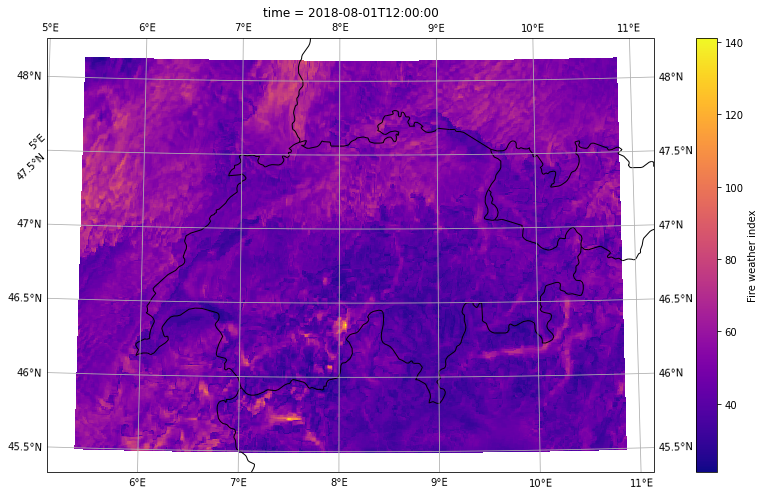

In [14]:
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.AlbersEqualArea(8.222665776, 46.800663464))
out[5].isel(time=0).plot(ax=ax, cmap="plasma", transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.gridlines(draw_labels=True)
#plt.savefig('/home/steidani/projects/unibe_forestfire/docs/figures/20180802_dmc_cosmo1.png', dpi=200)

In [122]:
# read COSMO-1 data
ds = xr.open_mfdataset('/home/steidani/windows/data/ecmwf/era5/2018_fwi/ECMWF_FWI_DMC*.nc', parallel=True)
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 15)
Coordinates:
  * time       (time) datetime64[ns] 2018-08-01 2018-08-02 ... 2018-08-15
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    dmc        (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.9.5 (http://m...
    history:                   Tue Nov 12 19:50:25 2019: cdo -P 8 -z zip_1 -m...
    Conventions:               CF-1.6
    Reference date:            20180801
    ECMWF fire model:          3.1
    License:                   Copernicus
    version:                   3.1
    NCO:                       netCDF Operators version 4.7.8 (Homepage = htt...
    cdo_openmp_thread_number:  8
    CDO:                       Climate Data Operators version 1.9.5 (http://m...

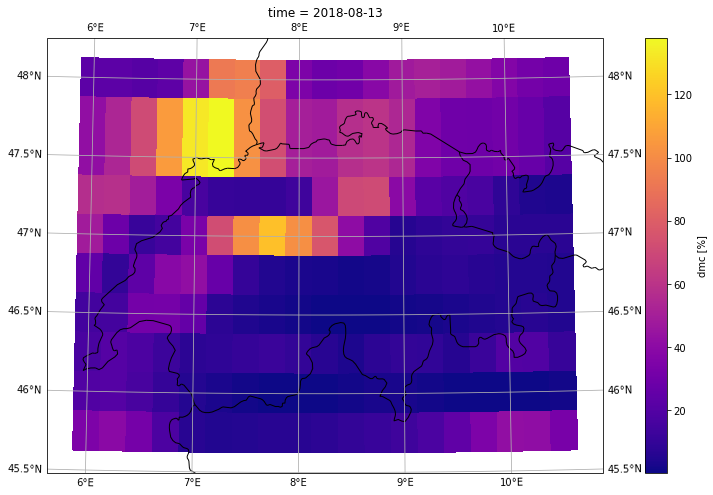

In [135]:
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.AlbersEqualArea(8.222665776, 46.800663464))
ds.dmc.isel(time=12).sel(latitude=slice(48,45.7), longitude=slice(5.9,10.5)).plot(ax=ax, cmap="plasma", transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.gridlines(draw_labels=True)
#plt.savefig('../docs/figures/topo_COSMO-1.png', dpi=200)